# 量的データ用（For quantitaive data）
[Methods]  
- Clustering methods : Kmeans, GMM, FSSEM, FSS-Kmeans    
- Allocation methods : random, proportional allocation, post stratification, optimal allocation

-------------
### ライブラリのインポート＆その他の設定（Importing Libraries & Other Settings）

In [1]:
# 基本的なライブラリ
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from scipy import stats

# Scikit-learn関連
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils.validation import check_X_y
from sklearn.metrics import silhouette_score
from sklearn.linear_model import Lasso

# 抽象基底クラス (ABC)
from abc import ABCMeta, abstractmethod

# タイピングのサポート
from typing import Optional

# シード設定
# from lightning.pytorch import seed_everything
# seed_everything(8)

# 可視化の設定
import matplotlib.pyplot as plt
import japanize_matplotlib
import itertools

plt.style.use("ggplot")

--------
### 実験設定

In [2]:
THRESHOLD = 2  # 外れ値除外のための閾値

SAMPLE_SIZE = 100  # 標本サイズ
DATA_SIZE = 100000  # データサイズ(df2)
N_TRIALS = 10000  # 試行回数（標本平均を求める回数）
N_EXPERIMENT = 1  # 誤差分散を求める回数
m_VALUE = 2  # 各クラスタの最小標本数(最適標本配分)
RANDOM_STATE = 0  # 乱数シード

ALLOCATION_LIST = [
    "Proportional",
    "Post",
    # "Optimal",
]  # ["Proportional", "Post", "Optimal"]
ALLOCATION_LIST_AND_RANDOM = [
    "Random",
    "Proportional",
    "Post",
    # "Optimal",
]  # ["Random", "Proportional" "Post", "Optimal"]
CRITERION_LIST = [
    "lasso",
    # "ml-std",
    # "sil"
    # "none",
    # "lasso",
    # "ml(obj)",
]  # ["ml",　"ml-std", "sil", "none", "checking", "lasso", "ml(obj)"] ※"tr"は使えない
CLUSTERING_METHOD_LIST = ["xmeans"]  # ["gmm", "kmeans", "xmeans"]

SELECT_MAXIMUM_FEATURES = (
    "yes"  # 特徴量をmaxになるまで選ぶ⇒"yes" or 基準値が最大になるまで⇒"no"
)
MAXIMUM_FEATURES_TO_SELECT = (
    5  # 選択される最大の特徴量("ml", "ml-std", "tr", "sil", "TSS(GMV)")
)

# クラスタ数を固定する場合（Kmeans, GMM)
N_CLUSTERS = 10  # クラスタ数
# クラスタ数を固定しない場合(xmeans)
K_MIN = 2  # 最小クラスタ数
K_MAX = 80  # 最大クラスタ数


FEATURES_LIST_CHECKING = [3]  # 特徴量を指定するとき（"checking")

stratification_methods = list(itertools.product(CRITERION_LIST, CLUSTERING_METHOD_LIST))
METHODS_NAME_DICT = {}
for method in stratification_methods:
    if method == ("none", "kmeans"):
        METHODS_NAME_DICT[method] = "K-means"
    if method == ("none", "xmeans"):
        METHODS_NAME_DICT[method] = "X-means"
    if method == ("none", "gmm"):
        METHODS_NAME_DICT[method] = "GMM"

    if method == ("ml", "kmeans"):
        METHODS_NAME_DICT[method] = "FSS-Kmeans-ml"
    if method == ("ml", "xmeans"):
        METHODS_NAME_DICT[method] = "FSS-Xmeans-ml"
    if method == ("ml", "gmm"):
        METHODS_NAME_DICT[method] = "FSS-GMM-ml"

    # if method == ("tr", "kmeans"):
    #     METHODS_NAME_DICT[method] = "FSS-Kmeans-tr"
    # if method == ("tr", "xmeans"):
    #     METHODS_NAME_DICT[method] = "FSS-Xmeans-tr"
    # if method == ("tr", "gmm"):
    #     METHODS_NAME_DICT[method] = "FSS-GMM-tr"

    if method == ("sil", "kmeans"):
        METHODS_NAME_DICT[method] = "FSS-Kmeans-silhouette"
    if method == ("sil", "xmeans"):
        METHODS_NAME_DICT[method] = "FSS-Xmeans-silouette"
    if method == ("sil", "gmm"):
        METHODS_NAME_DICT[method] = "FSS-GMM-silouette"

    if method == ("checking", "kmeans"):
        METHODS_NAME_DICT[method] = f"Kmeans ({FEATURES_LIST_CHECKING})"
    if method == ("checking", "xmeans"):
        METHODS_NAME_DICT[method] = f"Xmeans ({FEATURES_LIST_CHECKING})"
    if method == ("checking", "gmm"):
        METHODS_NAME_DICT[method] = f"GMM ({FEATURES_LIST_CHECKING})"

    if method == ("lasso", "kmeans"):
        METHODS_NAME_DICT[method] = "Kmeans-lasso"
    if method == ("lasso", "xmeans"):
        METHODS_NAME_DICT[method] = "Xmeans-lasso"
    if method == ("lasso", "gmm"):
        METHODS_NAME_DICT[method] = "GMM-lasso"

    if method == ("ml(obj)", "kmeans"):
        METHODS_NAME_DICT[method] = "FSS-Kmeans-ml(obj)"
    if method == ("ml(obj)", "xmeans"):
        METHODS_NAME_DICT[method] = "FSS-Xmeans-ml(obj)"
    # if method == ("ml(obj)", "gmm"):
    #     METHODS_NAME_DICT[method] = "FSS-GMM-ml(obj)"

    if method == ("ml-std", "kmeans"):
        METHODS_NAME_DICT[method] = "FSS-Kmeans-ml-std"
    if method == ("ml-std", "xmeans"):
        METHODS_NAME_DICT[method] = "FSS-Xmeans-ml-std"
    # if method == ("ml-std", "gmm"):
    #     METHODS_NAME_DICT[method] = "FSS-gmm-ml-std"

print("METHODS_NAME_DICT", METHODS_NAME_DICT)

METHODS_NAME_DICT {('lasso', 'xmeans'): 'Xmeans-lasso'}


-----------
### データの前処理（Data Preprocessing）

##### 外れ値を除去する関数

In [3]:
# 外れ値の除去
def remove_outliers_zscore(
    data: pd.DataFrame, metric: str, threshold: float = 2
) -> pd.DataFrame:
    z_scores = np.abs(stats.zscore(data[metric]))
    data = data[(z_scores < threshold)]
    return data

##### メルカリデータ（df1：全部, df2：一部）

In [4]:
# df1(all the data)
df1 = pd.read_csv(
    R"C:\Users\HaruMomozu\Documents\aug_first_cpn_data_for_ab_test_sensibility_tsukuba.csv"
)
obj1 = "GMV"
features_list1 = [
    "hist_4_day_buy_num",
    "hist_4_day_gmv",
    "his_4_day_is_buy",
    "hist_30_day_buy_days",
    "hist_30_day_buy_num",
    "hist_30_day_gmv",
    "hist_30_day_buy_recency",
    "hist_30_day_pay_days",
    "hist_30_day_atpu",
    "hist_30_day_gpv",
    "hist_30_day_pay_recency",
    "hist_30_day_list_days",
    "hist_30_day_list_num",
    "hist_30_day_list_recency",
    "hist_30_day_like_count",
    "hist_30_day_like_count_not_deleted",
    "hist_30_day_like_recency",
]

# df2(subset of the data)
df2 = df1.iloc[:DATA_SIZE]
obj2 = obj1
features_list2 = features_list1

##### 外れ値除去と標準化

In [5]:
df = df2  # choose from (df1, df2)
obj = obj2  # choose from (obj1, obj2)
features_list = features_list2  # choose from (features_list1, features_list2)

# 外れ値除去
df = remove_outliers_zscore(data=df, metric=obj, threshold=THRESHOLD)

# 標準化
X = df[features_list]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)
X_scaled = pd.DataFrame(scaled_features, columns=features_list)

# 目的変数
y = df[obj]

# 行を詰める
df = df.reset_index(drop=True)

print("外れ値除外前のデータ数:", DATA_SIZE)
print("外れ値除外後のデータ数:", len(df))

外れ値除外前のデータ数: 100000
外れ値除外後のデータ数: 99082


---------------
### Lasso で特徴量選択

In [6]:
if "lasso" in CRITERION_LIST:
    # Lasso モデルの作成と訓練
    lasso = Lasso(alpha=400)  # alpha は正則化の強さを表すハイパーパラメータ
    lasso.fit(X_scaled, y)

    # Lasso によって選択された特徴量の確認
    FEATURES_LIST_LASSO = np.where(lasso.coef_ != 0)[0]
    print("選択された特徴量のインデックス(Lasso):", FEATURES_LIST_LASSO)

選択された特徴量のインデックス(Lasso): [ 0  3  4  5 14]


-------------
### Wrapper法でクラスタリング

##### Wrapper Class

In [7]:
class Wrapper(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        maximum_features_to_select: int,
        n_clusters: int,
        criterion: str = "ml",
        clustering_method: str = "gmm",
        random_state: int = 0,
        select_maximum_features: str = "yes",
        k_min: int = 2,
        k_max: int = 10,
    ):
        self.maximum_features_to_select = maximum_features_to_select  # 特徴量数
        self.n_clusters = n_clusters  # クラスタ数
        self.criterion = criterion  # 特徴量選択基準
        self.clustering_method = clustering_method  # クラスタリング手法
        self.random_state = random_state
        self.select_maximum_features = select_maximum_features
        self.k_min = k_min
        self.k_max = k_max

    def fss(self, X: pd.DataFrame, y: pd.DataFrame) -> "Wrapper":
        X, y = check_X_y(X, y)
        n_all_features = X.shape[1]  # 総特徴量数

        ##### 初期化 #####
        features_score_dict = {}  # スコアの推移の確認用（キー：特徴量の数, 値：スコア）
        current_features = []  # 選択された特徴量

        if self.criterion == "ml-std":
            iter = 0
            features_to_compare = [0]  # 比較する特徴量
            remaining_features = [
                i + 1 for i in range(n_all_features - 1)
            ]  # 選択されていない特徴量
        else:
            remaining_features = list(range(n_all_features))  # 選択されていない特徴量

        if self.select_maximum_features == "no":
            best_score = -np.inf  # スコア（特徴量を最大数選ぶとは限らないとき）

        ##### 特徴量選択とクラスタリング #####
        while len(current_features) < self.maximum_features_to_select:
            best_feature = None
            # スコア初期化（特徴量を最大数選ぶとき）
            if self.select_maximum_features == "yes":
                best_score = -np.inf

            # 追加するとスコアが一番高くなる特徴量を選ぶ
            for feature in remaining_features:
                temp_features = current_features + [
                    feature
                ]  # スコアを調べたい特徴量サブセット

                if self.criterion == "ml-std":
                    iter += 1
                    score_current, labels_current, n_clusters_current = (
                        self.crit_std_current(
                            X[:, features_to_compare], X[:, temp_features], y
                        )
                    )
                    score_temp, labels_temp, n_clusters_temp = self.crit_std_temp(
                        X[:, features_to_compare], X[:, temp_features], y
                    )
                    if (score_temp > score_current) or (
                        self.select_maximum_features == "yes" and best_feature is None
                    ):
                        best_feature = feature
                        features_to_compare = temp_features
                        best_score = score_temp
                        best_labels = labels_temp
                        best_n_clusters = n_clusters_temp
                    elif iter == 1:
                        best_feature = 0
                        features_to_compare = [0]
                        best_score = score_current
                        best_labels = labels_current
                        best_n_clusters = n_clusters_current
                else:
                    score, labels, n_clusters = self.crit(X[:, temp_features])
                    if score > best_score:
                        best_score = score
                        best_feature = feature
                        best_labels = labels
                        best_n_clusters = n_clusters

            # 選択された特徴量をcurrent_featuresに追加し、remaining_features から除外
            if best_feature is not None:
                current_features.append(best_feature)
                if best_feature in remaining_features:
                    remaining_features.remove(best_feature)

                num_of_features = len(current_features)
                print(
                    "num_of_features:",
                    num_of_features,
                    "current_features:",
                    current_features,
                    ", score:",
                    best_score,
                    "best_n_clusters:",
                    best_n_clusters,
                )
                features_score_dict[str(num_of_features)] = best_score  # 確認用

            else:
                break

        ##### 最終的な特徴量とクラスタリング結果 #####
        self.final_selected_features = current_features
        self.final_cluster_assignments = best_labels
        self.final_n_clusters = best_n_clusters
        self.features_score_dict = features_score_dict

        return self

    def crit(self, X: pd.DataFrame) -> float:
        # クラスタリング手法がGMMの場合
        if self.clustering_method == "gmm":
            gmm = GaussianMixture(
                n_components=self.n_clusters,
                random_state=self.random_state,
                init_params="kmeans",
            )
            gmm.fit(X)
            labels = gmm.predict(X)
            n_clusters = len(np.unique(labels))

            if self.criterion == "ml":
                score = gmm.score(X)

            elif self.criterion == "sil":
                score = silhouette_score(X, labels)

            # elif self.criterion == "tr":
            #     means = gmm.means_  # 平均ベクトル
            #     covariances = (
            #         gmm.covariances_ + 1e-7
            #     )  # 共分散行列(各要素に微小な数が加算される)
            #     weights = gmm.weights_  # 混合比率
            #     overall_mean = np.sum(
            #         weights[:, np.newaxis] * means, axis=0
            #     )  # 標本平均 #np.newaxisを使って1次元配列から2次元配列にする
            #     S_W = np.sum(weights[:, np.newaxis, np.newaxis] * covariances, axis=0)
            #     S_B = np.sum(
            #         weights[:, np.newaxis, np.newaxis]
            #         * np.einsum(
            #             "...i,...j->...ij", means - overall_mean, means - overall_mean
            #         ),
            #         axis=0,
            #     )
            #     score = np.trace(np.linalg.solve(S_W, S_B))

        # クラスタリング手法が kmeans または xmeans の場合
        if self.clustering_method == "kmeans" or self.clustering_method == "xmeans":
            if self.clustering_method == "kmeans":
                model = KMeans(
                    n_clusters=self.n_clusters,
                    random_state=self.random_state,
                )
            if self.clustering_method == "xmeans":
                model = self.xmeans(X)

            model.fit(X)
            labels = model.predict(X)
            n_clusters = len(np.unique(labels))

            if self.criterion == "ml":
                score = model.score(X)

            elif self.criterion == "ml(obj)":
                tss = 0
                for k in np.unique(labels):
                    y_k = y[labels == k]
                    mean_y_k = np.mean(y_k)
                    tss += np.sum((y_k - mean_y_k) ** 2)
                score = -tss

            elif self.criterion == "sil":
                score = silhouette_score(X, labels)

            # elif self.criterion == "tr":
            #     cluster_centers = model.cluster_centers_
            #     sw_i_list = []
            #     for i in range(n_clusters):
            #         cluster_points = X[labels == i]
            #         if cluster_points.shape[0] <= 2:
            #             # データポイントが1つの場合はゼロ行列を使用
            #             sw_i = np.zeros((X.shape[1], X.shape[1])) + 1e-7
            #         else:
            #             sw_i = (np.cov(cluster_points, rowvar=False) + 1e-7) * np.sum(
            #                 labels
            #                 == i  # データ数を重みに使う代わりにデータの割合を使う
            #             )
            #             if np.isscalar(sw_i):  # スカラー値のとき
            #                 sw_i = np.array([[sw_i]])
            #         sw_i_list.append(sw_i)
            #     # 全クラスターの S_W を合計
            #     S_W = np.sum(sw_i_list, axis=0)
            #     # クラスター間散布行列 S_B を計算
            #     overall_mean = np.mean(X, axis=0)
            #     S_B = sum(
            #         (np.sum(labels == i) / X.shape[0])  # 割合にする
            #         * np.outer(
            #             cluster_centers[i] - overall_mean,
            #             cluster_centers[i] - overall_mean,
            #         )
            #         # *(cluster_centers[i] - overall_mean) @ (cluster_centers[i] - overall_mean).T
            #         for i in range(n_clusters)
            #     )
            #     # 散乱分離性を計算
            #     score = np.trace(np.linalg.solve(S_W, S_B))

        return score, labels, n_clusters

    def crit_std_current(self, current_X, temp_X, y):
        score_current, labels, n_clusters = self.crit_std(current_X, current_X)
        score_temp, _, _ = self.crit_std(temp_X, current_X)
        score = -score_current * score_temp
        return score, labels, n_clusters

    def crit_std_temp(self, current_X, temp_X, y):
        score_current, _, _ = self.crit_std(current_X, temp_X)
        score_temp, labels, n_clusters = self.crit_std(temp_X, temp_X)
        score = -score_current * score_temp
        return score, labels, n_clusters

    def crit_std(self, X1, X2):  # X2空間上でしたクラスタリングの結果をX1空間上で評価
        if self.clustering_method == "kmeans" or self.clustering_method == "xmeans":
            if self.clustering_method == "kmeans":
                model = KMeans(
                    n_clusters=self.n_clusters,
                    random_state=self.random_state,
                )
            if self.clustering_method == "xmeans":
                model = self.xmeans(X2)

            model.fit(X2)
            labels = model.predict(X2)
            n_clusters = len(np.unique(labels))

            # クラスタラベルを使ってX1空間上でのSSEを計算
            centroids_X1 = np.zeros((n_clusters, X1.shape[1]))  # クラスタ数 × X1の次元
            for i in range(n_clusters):
                # 各クラスタのデータ点の平均を計算（X1空間上）
                cluster_points = X1[labels == i]
                centroids_X1[i, :] = np.mean(cluster_points, axis=0)

            # 総平方和(SSE)を計算
            sse = 0.0
            for i, label in enumerate(labels):
                centroid = centroids_X1[label]  # データポイントに対応するクラスタの重心
                sse += np.sum(
                    (X1[i] - centroid) ** 2
                )  # データ点と重心の距離の二乗を加算
            score = sse

            return score, labels, n_clusters

    def compute_bic(self, X, kmeans):
        # クラスタリング結果の取得
        labels = kmeans.labels_
        clusters = kmeans.cluster_centers_
        n_clusters = len(clusters)
        n = len(X)
        m = X.shape[1]
        # クラスター内の分散の合計
        variance = np.sum(
            [
                np.linalg.norm(X[labels == i] - clusters[i], axis=1).sum()
                for i in range(n_clusters)
            ]
        )
        # BIC の計算
        bic = np.log(n) * n_clusters * m + n * np.log(variance / n)
        return bic

    def xmeans(self, X):
        kmeans = KMeans(
            n_clusters=self.k_min, random_state=self.random_state
        )  # 初期クラスター数で KMeans を実行
        kmeans.fit(X)
        best_bic = self.compute_bic(X, kmeans)
        best_kmeans = kmeans
        for k in range(self.k_min + 1, self.k_max + 1):
            kmeans = KMeans(n_clusters=k, random_state=self.random_state)
            kmeans.fit(X)
            # BIC を計算
            current_bic = self.compute_bic(X, kmeans)
            # BIC が改善される場合、クラスタ数を更新
            if current_bic < best_bic:
                best_bic = current_bic
                best_kmeans = kmeans
        # 最適なクラスタリング結果を返す
        return best_kmeans

    def get_feature_index_out(self) -> NDArray:
        return np.array(
            self.final_selected_features
        )  # 最終的に選択された特徴量のインデックス

    def get_final_cluster_assignments(self) -> NDArray:
        return self.final_cluster_assignments  # 最終的なクラスタリング結果

    def get_final_n_clusters(self) -> int:
        return self.final_n_clusters  # 最終的なクラスタ数

    def get_features_score_dict(self) -> dict:
        return self.features_score_dict  # スコアの推移（確認用）

##### Wrapper classでクラスタリングしたとき

In [8]:
# Wrapper法を実装するための関数
def process_wrapper(name: str, instance: "Wrapper", X: pd.DataFrame, y: pd.DataFrame):
    instance.fss(X, y)
    selected_features_index = instance.get_feature_index_out()
    cluster_label = instance.get_final_cluster_assignments()
    cluster_size = np.unique(cluster_label, return_counts=True)[1]
    features_score_dict = instance.get_features_score_dict()
    n_clusters = instance.get_final_n_clusters()

    return (
        selected_features_index,
        cluster_label,
        cluster_size,
        features_score_dict,
        n_clusters,
    )


# Wrapperインスタンスのリスト
instances = []
for method, name in METHODS_NAME_DICT.items():
    if method[0] != "none" and method[0] != "checking" and method[0] != "lasso":
        instances.append(
            (
                name,
                Wrapper(
                    maximum_features_to_select=MAXIMUM_FEATURES_TO_SELECT,
                    n_clusters=N_CLUSTERS,
                    criterion=method[0],
                    clustering_method=method[1],
                    random_state=RANDOM_STATE,
                    select_maximum_features=SELECT_MAXIMUM_FEATURES,
                    k_min=K_MIN,
                    k_max=K_MAX,
                ),
            )
        )


# 辞書の初期化
selected_features_index_dict = {}
cluster_label_dict = {}
cluster_size_dict = {}
N_CLUSTER_DICT = {}
features_score_dict_list = []

# 各インスタンスに対して処理を実行
for name, instance in instances:
    print("[", name, "]")

    (
        selected_features_index,
        cluster_label,
        cluster_size,
        features_score_dict,
        n_clusters,
    ) = process_wrapper(name, instance, X_scaled, y)

    selected_features_index_dict[name] = selected_features_index
    cluster_label_dict[name] = cluster_label
    cluster_size_dict[name] = cluster_size
    N_CLUSTER_DICT[name] = n_clusters
    features_score_dict_list.append(features_score_dict)

    print("選ばれた特徴量：", selected_features_index)
    print("最終的な各層のクラスタサイズ : ", cluster_size)

##### Wrapper法のスコア推移

In [9]:
i = -1
for name, instance in instances:
    i += 1
    # 棒グラフを作成
    plt.bar(features_score_dict_list[i].keys(), features_score_dict_list[i].values())
    # for key, value in features_score_dict_list[i].items():
    #     rounded_value = round(value, 2)
    #     plt.text(key, value + 0.3, str(rounded_value), ha="center", fontsize=18)
    plt.title(f"{name}", fontsize=40)
    plt.xlabel("Number of features", fontsize=30)
    plt.ylabel("Evaluation value", fontsize=30)
    plt.tick_params(axis="both", labelsize=21)
    plt.show()

----------------
### Kmeans, GMM, Xmeansでクラスタリングしたとき

##### 準備（Xmeans）

In [10]:
def compute_bic(X, kmeans):
    labels = kmeans.labels_
    clusters = kmeans.cluster_centers_
    n_clusters = len(clusters)
    n = len(X)
    m = X.shape[1]
    variance = np.sum(
        [
            np.linalg.norm(X[labels == i] - clusters[i], axis=1).sum()
            for i in range(n_clusters)
        ]
    )
    bic = np.log(n) * n_clusters * m + n * np.log(variance / n)
    return bic


def xmeans(X, k_min=2, k_max=10):
    kmeans = KMeans(n_clusters=k_min, random_state=RANDOM_STATE)
    kmeans.fit(X)
    best_bic = compute_bic(X, kmeans)
    best_kmeans = kmeans
    for k in range(k_min + 1, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
        kmeans.fit(X)
        current_bic = compute_bic(X, kmeans)
        if current_bic < best_bic:
            best_bic = current_bic
            best_kmeans = kmeans
    return best_kmeans

##### クラスタリング結果

In [11]:
clustering_methods = []
for method, name in METHODS_NAME_DICT.items():
    if method[0] == "none" or method[0] == "checking" or method[0] == "lasso":
        clustering_methods.append(name)
        if method[1] == "kmeans":
            model = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE)
        if method[1] == "gmm":
            model = GaussianMixture(
                n_components=N_CLUSTERS, random_state=RANDOM_STATE, init_params="kmeans"
            )
        if method[1] == "xmeans":
            model = xmeans(X_scaled, k_min=K_MIN, k_max=K_MAX)

        if method[0] == "none":
            labels = model.fit_predict(X_scaled)
        if method[0] == "checking":
            labels = model.fit_predict(X_scaled.iloc[:, FEATURES_LIST_CHECKING])
        if method[0] == "lasso":
            labels = model.fit_predict(X_scaled.iloc[:, FEATURES_LIST_LASSO])
        cluster_size = np.bincount(labels)
        n_clusters = len(np.unique(labels))

        cluster_label_dict[name] = labels
        cluster_size_dict[name] = cluster_size
        N_CLUSTER_DICT[name] = n_clusters

        print("[", name, "]")
        print("各層のクラスタサイズ : ", cluster_size_dict[name])
        print("クラスタ数：", N_CLUSTER_DICT[name])
        print()

[ Xmeans-lasso ]
各層のクラスタサイズ :  [2108  746 4825  129  265 1628    2  115 1121 1797    8   13 1161 3888
  445  384 1338   34 3358 1069 5716 7792   83  626 4539 3703 1745  565
  237  478 1435    2   16    6 1779   35 1134 3421  131  381 1422  132
 2059  183  722 2081   42  237    2  451 2135   40  684  780  339 2174
  517  239    1 2619   93 2158 3236 3373  846 2320 2303 1536  456 6647
  948   46    3]
クラスタ数： 73



-----------------------------
### 標本配分（Allocation)

##### 基底クラス（層化抽出）

In [12]:
class BaseAllocation(metaclass=ABCMeta):  # 抽象基底クラス（ABC）
    # 初期化クラス（n_samples(標本サイズ), H(クラスタ数)）
    def __init__(
        self,
        sample_size: int,
        H: int,
        random_state: int,
        criterion: str,
        clustering_method: str,
        methods_name_dict: dict,
    ):
        self.sample_size = sample_size
        self.H = H
        self.random_state = random_state
        self.criterion = criterion
        self.clustering_method = clustering_method
        self.methods_name_dict = methods_name_dict

    @abstractmethod
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """標本配分を解く

        Args:
            X (NDArray): データ (N x M)
            y (NDArray): 目的変数 (N)

        Raises:
            NotImplementedError: _description_

        Returns:
            NDArray: 各クラスタの標本数 (H, )

        Note:
            M: 特徴量数
            H: クラスタ数
        """
        # 具象クラスがsolveメゾッドを実装しない場合はNotImpleamentedErrorが発生
        raise NotImplementedError

    def clustering(self, X: NDArray) -> tuple[NDArray, NDArray]:
        for method, name in self.methods_name_dict.items():
            if method[0] == self.criterion and method[1] == self.clustering_method:
                cluster_label = cluster_label_dict[name]
                cluster_size = cluster_size_dict[name]

        # インスタンス変数として設定
        self.cluster_label = cluster_label
        self.N = cluster_size

        return cluster_label, cluster_size

##### 単純無作為抽出のクラス

In [13]:
# class Random(BaseAllocation):
#     # 抽象メゾッドを具象化
#     def solve(self, X: NDArray, y: NDArray) -> NDArray:
#         """ランダムにn_samplesの標本を選択する"""
#         n = np.array([self.sample_size])
#         return n

#     def clustering(self, X: NDArray) -> tuple[NDArray, NDArray]:
#         # cluster_labelのすべての要素は0（すべてのデータを同じクラスタに属させている）
#         cluster_label = np.zeros(
#             X.shape[0]
#         )  # cluster_label = [0,0,0,,...(要素数：データ数）]
#         # クラスタサイズ＝データ数
#         cluster_size = np.array([len(cluster_label)])  # cluster_size=[データ数]
#         return cluster_label, cluster_size

##### 比例配分のクラス

In [14]:
class Proportional(BaseAllocation):
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """各クラスタ数に比例した標本数で分割する"""
        n: NDArray = np.round(self.N / self.N.sum() * self.sample_size).astype(int)

        if n.sum() > self.sample_size:
            # nの合計がn_samplesより大きい場合は一番標本数が多いクラスタから削る
            n[np.argmax(n)] -= n.sum() - self.sample_size

        if n.sum() < self.sample_size:
            # nの合計がn_samplesより小さい場合は一番標本数が多いクラスタにたす
            n[np.argmax(n)] += -n.sum() + self.sample_size

        return n

##### 事後層化のクラス

In [15]:
class Post(BaseAllocation):
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """ランダムにn_samplesの標本を選択する"""
        n = np.array([self.sample_size])

        return n  # （例）n=[標本サイズ]

##### 最適標本配分のクラス

In [16]:
class Optimal(BaseAllocation):
    def __init__(
        self,
        sample_size: int,
        H: int,
        m: NDArray,  # 標本サイズ下限
        M: Optional[NDArray] = None,  # 標本サイズ上限 #Optional(Noneである可能性がある)
        random_state: int = 0,
        criterion: str = "tr",
        clustering_method: str = "kmeans",
        methods_name_dict: dict = {},
    ):
        super().__init__(
            sample_size,
            H,
            random_state,
            criterion,
            clustering_method,
            methods_name_dict,
        )  # 基底クラスBaseAllocation（スーパークラス）の初期化メゾッドを呼び出す
        self.m = m  # 各クラスタの最小標本サイズ (H, )
        self.M = M  # 各クラスタの最大標本サイズ (H, ), (指定しない場合はクラスタサイズ)

    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        # S:クラスタ毎の目的変数のvarianceを要素とする配列 (H, )
        S = np.array([np.var(y[self.cluster_label == h]) for h in range(self.H)])
        d = (self.N**2) * S  # (H, )
        n = self._simple_greedy(n=self.m.copy(), d=d)

        # 制約チェック
        self._check_constraints(n)

        return n

    def _simple_greedy(self, n: NDArray, d: NDArray) -> NDArray:
        M = self.M.copy() if self.M is not None else self.N.copy()
        I = np.arange(self.H)  # noqa #クラスタのインデックス
        while (n.sum() != self.sample_size) and len(I) != 0:
            delta = np.zeros(self.H)
            delta[I] = (d / (n + 1) - d / n)[I]
            h_star = np.argmin(delta[I])
            h_star = I[h_star]

            if n[h_star] + 1 <= M[h_star]:
                n[h_star] = n[h_star] + 1
            else:
                # Iの要素h_starを削除
                I_ = I.tolist()
                I_ = [i for i in I_ if i != h_star]
                I = np.array(I_)  # noqa

        return n

    def _check_constraints(self, n: NDArray):
        assert (
            n.sum() <= self.sample_size
        ), f"Total sample size is over than {self.sample_size}"
        assert np.all(n >= self.m), "Minimum sample size constraint is not satisfied"
        if self.M is not None:
            assert np.all(
                n <= self.M
            ), "Maximum sample size constraint is not satisfied"

##### 各ポリシーを生成

In [17]:
# 各ポリシーの生成を行う関数
def create_policies(
    methods_name_dict: dict,
    allocation_list: list,
    sample_size: int,
    H_dict: dict,
    random_state: int,
    m_value: int,
):  # -> dict[list[str] : list[BaseAllocation]]:
    policies_dict = {}
    for method, name in methods_name_dict.items():
        policies: list[BaseAllocation] = [
            # Random(
            #     sample_size=sample_size,
            #     H=H_dict[name],
            #     random_state=random_state,
            #     criterion=method[0],
            #     clustering_method=method[1],
            #     methods_name_dict=methods_name_dict,
            # )
        ]
        if "Proportional" in allocation_list:
            policies.append(
                Proportional(
                    sample_size=sample_size,
                    H=H_dict[name],
                    random_state=random_state,
                    criterion=method[0],
                    clustering_method=method[1],
                    methods_name_dict=methods_name_dict,
                )
            )
        if "Post" in allocation_list:
            policies.append(
                Post(
                    sample_size=sample_size,
                    H=H_dict[name],
                    random_state=random_state,
                    criterion=method[0],
                    clustering_method=method[1],
                    methods_name_dict=methods_name_dict,
                )
            )
        if "Optimal" in allocation_list:
            policies.append(
                Optimal(
                    sample_size=sample_size,
                    H=H_dict[name],
                    random_state=random_state,
                    m=np.full(H_dict[name], m_value),
                    M=None,
                    criterion=method[0],
                    clustering_method=method[1],
                    methods_name_dict=methods_name_dict,
                )
            )
        policies_dict[name] = policies
    return policies_dict


policies_dict = create_policies(
    methods_name_dict=METHODS_NAME_DICT,
    allocation_list=ALLOCATION_LIST,
    sample_size=SAMPLE_SIZE,
    H_dict=N_CLUSTER_DICT,
    random_state=RANDOM_STATE,
    m_value=m_VALUE,
)

print("policies_dict", policies_dict)

policies_dict {'Xmeans-lasso': [<__main__.Proportional object at 0x000001F52D490BF0>, <__main__.Post object at 0x000001F52D491D00>]}


##### 標本配分の計算

In [18]:
allocations_dict = {}
for name, policies in policies_dict.items():
    # それぞれの戦略で各クラスタの標本数を求解
    allocations: list[dict] = []  # 各戦略の実行結果が辞書形式で追加される
    for policy in policies:
        # policyを用いてXをクラスタリング
        cluster_label, _ = policy.clustering(X_scaled)
        n = policy.solve(X_scaled, y)
        allocations.append(
            {
                "policy": policy.__class__.__name__,
                "n": n,
                "cluster_label": cluster_label,
            }
        )
    allocations_dict[name] = allocations

------------
### 標本抽出と誤差分散削減率の計算

##### 母平均を推定する関数

In [19]:
def estimate_y_mean(n: NDArray, cluster_label: NDArray, y: NDArray) -> NDArray:
    """実際にサンプリングを行って目的変数の平均を推定

    Args:
        n (NDArray): 各クラスタの標本数 (H, )
        cluster_label (NDArray): クラスタラベル (N, )
        y (NDArray): 目的変数 (N, )

    Returns:
        NDArray: 推定された目的変数の平均

    Note:
        N: データ数
        H: クラスタ数
    """
    # cluster_labelからユニークなクラスタラベルを取得し、母集団の各クラスタのサイズNを取得
    N = np.unique(cluster_label, return_counts=True)[1]  # クラスタサイズ (H, )
    weights = N / N.sum()
    y_hat = 0
    for h in range(n.shape[0]):  # n.shape[0]:層の数
        if n[h] != 0:
            y_cluster = y[cluster_label == h]
            if n[h] <= len(y_cluster):
                sample: NDArray = np.random.choice(y_cluster, n[h], replace=False)
                y_sample_mean = sample.mean()  # サンプリングした標本の平均
                y_hat += y_sample_mean * weights[h]

    return y_hat


def estimate_y_mean_post(n: NDArray, cluster_label: NDArray, y: NDArray) -> NDArray:
    N = np.unique(cluster_label, return_counts=True)[1]
    weights = N / N.sum()
    y_hat = 0
    indices = np.arange(N.sum())
    y_array = np.array(y.tolist())
    n_indices = np.random.choice(indices, n[0], replace=False)
    n_label = np.array([cluster_label[i] for i in n_indices])
    n_new_labels = np.unique(n_label)
    for h in n_new_labels:
        index = np.where(n_label == h)[0]
        sample = y_array[n_indices[index]]
        y_sample_mean = sample.mean()  # サンプリングした標本の平均
        y_hat += y_sample_mean * weights[h]
    return y_hat

##### 誤差分散削減率の計算する関数

In [20]:
def cauculate_reduction_rate(
    X: pd.DataFrame,
    y: pd.DataFrame,
    policies_dict: dict,
    random_std: float,
) -> dict:
    reduction_rate_dict = {}
    error_variance_dict = {}

    # 各戦略の標本数に基づいて目的変数の平均を推定
    y_hats_dict = {}
    for name, allocations in allocations_dict.items():
        y_hats = []
        for i in range(N_TRIALS):
            for allocation in allocations:
                if allocation["policy"] == "Post":
                    y_hat = estimate_y_mean_post(
                        allocation["n"], allocation["cluster_label"], y
                    )
                else:
                    y_hat = estimate_y_mean(
                        allocation["n"], allocation["cluster_label"], y
                    )
                y_hats.append(
                    {
                        "policy": allocation["policy"],
                        "y_hat": y_hat,
                        "random_state": i,
                    }
                )
        y_hats_dict[name] = y_hats

    for name, y_hats in y_hats_dict.items():
        y_hat_df = pd.DataFrame(y_hats)
        y_hat_df["error"] = (
            y_hat_df["y_hat"] - y.mean()
        )  # 真の平均からの誤差をerrorカラムに追加

        # random_allocation以外の誤差分散
        non_random_allocation_std = (
            y_hat_df[y_hat_df["policy"] != "Random"].groupby("policy")["error"].var()
        )

        # 削減率
        reduction_rate = (1 - non_random_allocation_std / random_std) * 100

        ## policyの順番をpoliciesの順番に調整
        reduction_rate = reduction_rate.reindex(
            [policy.__class__.__name__ for policy in policies]
        )

        error_variance = pd.concat(
            [
                pd.Series(random_std, index=["Random"]),
                non_random_allocation_std,
            ]
        )

        reduction_rate_dict[name] = reduction_rate
        error_variance_dict[name] = error_variance
    return reduction_rate_dict, error_variance_dict

##### 実験回数分の誤差分散削減率を計算（単純無作為抽出）

In [21]:
RANDOM_STD_LIST = []
for exp in range(N_EXPERIMENT):
    np.random.seed(exp)
    y_hats = []
    for random_state in range(N_TRIALS):
        sample = np.random.choice(y, SAMPLE_SIZE, replace=False)
        y_hat_random = sample.mean()
        y_hats.append(y_hat_random)
    errors = np.array(y_hats) - y.mean()
    random_std = errors.var()
    RANDOM_STD_LIST.append(random_std)
print(RANDOM_STD_LIST)

[232437.5132330648]


##### 実験回数分の誤差分散削減率を計算（層化抽出）

In [22]:
all_reduction_rate = []
all_error_variance = []
for exp in range(N_EXPERIMENT):
    np.random.seed(exp)
    reduction_rate_dict, error_variance_dict = cauculate_reduction_rate(
        X_scaled, y, policies_dict, RANDOM_STD_LIST[exp]
    )
    all_reduction_rate.append(reduction_rate_dict)
    all_error_variance.append(error_variance_dict)

In [23]:
results_reduction_rate = {}
results_error_variance = {}
results_list = [results_reduction_rate, results_error_variance]
all_results = [all_reduction_rate, all_error_variance]

for i in range(2):
    for method, name in METHODS_NAME_DICT.items():
        results_list[i][name] = {}
        if i == 0:
            results_list[i][name]["Random"] = [0 for exp in range(N_EXPERIMENT)]
        if i == 1:
            results_list[i][name]["Random"] = RANDOM_STD_LIST
        for allocation_method in ALLOCATION_LIST:
            results_list[i][name][allocation_method] = []
    for dict in all_results[i]:
        for name, policy in dict.items():
            for allocation_method in ALLOCATION_LIST:
                results_list[i][name][allocation_method].append(
                    policy[allocation_method]
                )

mean_results_reduction_rate = {}
mean_results_error_variance = {}
mean_results_list = [mean_results_reduction_rate, mean_results_error_variance]


for i in range(2):
    for method, name in METHODS_NAME_DICT.items():
        mean_results_list[i][name] = {}
        if i == 0:
            mean_results_list[i][name]["Random"] = 0
        if i == 1:
            mean_results_list[i][name]["Random"] = sum(RANDOM_STD_LIST) / N_EXPERIMENT
        for allocation_method in ALLOCATION_LIST:
            mean_results_list[i][name][allocation_method] = []
    for name, dict in results_list[i].items():
        for allocation_method in ALLOCATION_LIST:
            mean_results_list[i][name][allocation_method] = np.mean(
                np.array(dict[allocation_method])
            )

for method, allocations in results_reduction_rate.items():
    del allocations["Random"]
for method, allocations in mean_results_reduction_rate.items():
    del allocations["Random"]

print(results_reduction_rate)
print(mean_results_reduction_rate)
print(results_error_variance)
print(mean_results_error_variance)

{'Xmeans-lasso': {'Proportional': [38.972186347389695], 'Post': [41.67421969346249]}}
{'Xmeans-lasso': {'Proportional': 38.972186347389695, 'Post': 41.67421969346249}}
{'Xmeans-lasso': {'Random': [232437.5132330648], 'Proportional': [141851.5324346362], 'Post': [135570.99331829642]}}
{'Xmeans-lasso': {'Random': 232437.5132330648, 'Proportional': 141851.5324346362, 'Post': 135570.99331829642}}


------------------
### 可視化

##### 分布を確認

C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_20968\2381257429.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(allo_data, labels=allo_labels)


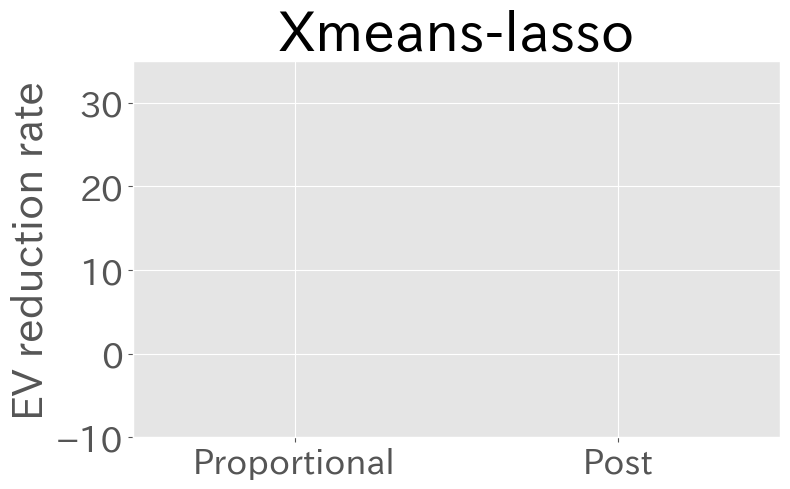

C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_20968\2381257429.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(allo_data, labels=allo_labels)  # 箱ひげ図を描く


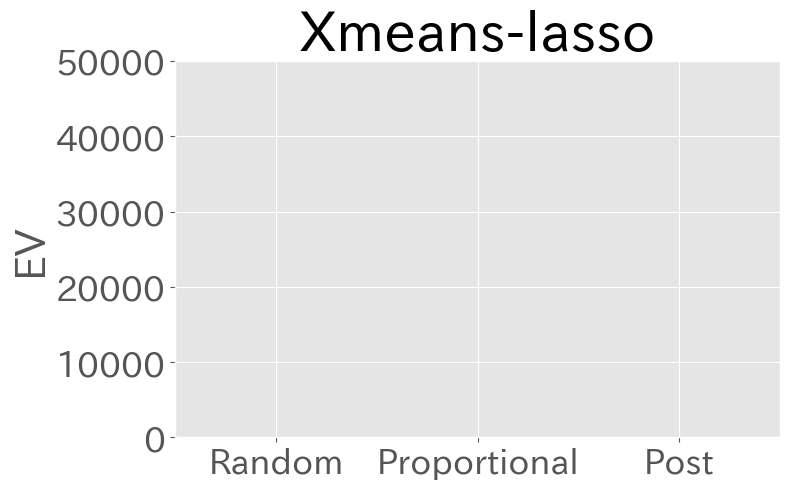

In [24]:
# 誤差分散削減率の箱ひげ図
fig, axs = plt.subplots(
    1, len(results_reduction_rate), figsize=(8 * len(results_reduction_rate), 5)
)  # サブプロットを作成


# 各methodに対して
plot_idx = 0  # サブプロットのインデックス
for i, (method, allocations) in enumerate(results_reduction_rate.items()):
    allo_data = list(allocations.values())  # allo1, allo2, allo3 のデータリスト
    allo_labels = list(allocations.keys())  # alloのラベルリスト
    if len(results_reduction_rate) == 1:
        ax = axs
    else:
        ax = axs[plot_idx]
    ax.boxplot(allo_data, labels=allo_labels)
    # グラフタイトルを設定
    ax.set_title(f"{method}", fontsize=40)
    ax.set_ylabel("EV reduction rate", fontsize=30)
    ax.tick_params(axis="both", which="major", labelsize=25)
    ax.set_ylim(-10, 35)
    plot_idx += 1

# グラフを表示
plt.tight_layout()  # レイアウトを調整
plt.show()


# 誤差分散の箱ひげ図
fig, axs = plt.subplots(
    1, len(results_error_variance), figsize=(8 * len(results_error_variance), 5)
)  # サブプロットを作成


plot_idx = 0  # サブプロットのインデックス
for i, (method, allocations) in enumerate(results_error_variance.items()):
    allo_data = list(allocations.values())  # allo1, allo2, allo3 のデータリスト
    allo_labels = list(allocations.keys())  # alloのラベルリスト
    if len(results_reduction_rate) == 1:
        ax = axs
    else:
        ax = axs[plot_idx]
    ax.boxplot(allo_data, labels=allo_labels)  # 箱ひげ図を描く
    ax.set_title(f"{method}", fontsize=40)  # タイトル設定
    ax.set_ylabel("EV", fontsize=30)
    ax.tick_params(axis="both", which="major", labelsize=25)
    ax.set_ylim(0, 50000)
    plot_idx += 1  # 次のサブプロットへ移動

# レイアウト調整して表示
plt.tight_layout()
plt.show()

##### 全実験の平均

['Proportional', 'Post']
[38.972186347389695, 41.67421969346249]


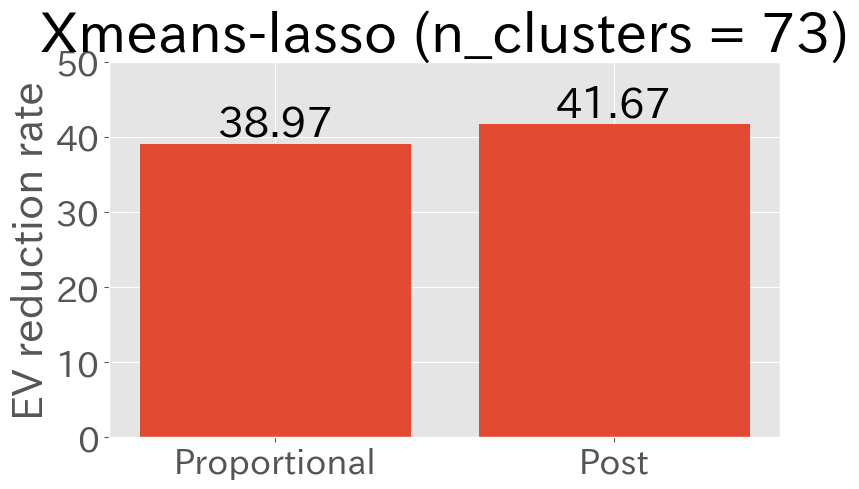

['Random', 'Proportional', 'Post']
[232437.5132330648, 141851.5324346362, 135570.99331829642]


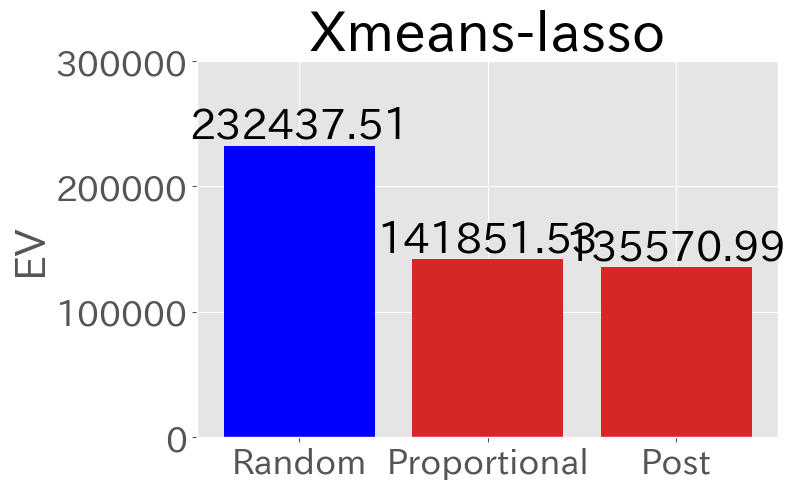

In [25]:
# グラフ作成
fig, axs = plt.subplots(
    1,
    len(mean_results_reduction_rate),
    figsize=(8 * len(mean_results_reduction_rate), 5),
)  # サブプロットを作成


plot_idx = 0
for method, dict in mean_results_reduction_rate.items():
    x = [a for a in ALLOCATION_LIST]
    values = [val for val in mean_results_reduction_rate[method].values()]  # y軸
    print(x)
    print(values)
    if len(mean_results_reduction_rate) == 1:
        ax = axs
    else:
        ax = axs[plot_idx]
    bars = ax.bar(x, values)
    # 各バーの上に値を表示
    for bar in bars:
        yval = bar.get_height()  # 各バーの高さ（値）
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            round(yval, 2),
            ha="center",
            va="bottom",
            fontsize=30,
        )  # 値をバーの上に表示
        # plt.ylabel("誤差分散削減率 (%)")
    ax.set_ylabel("EV reduction rate", fontsize=30)
    ax.set_ylim(0, 50)
    ax.tick_params(axis="both", which="major", labelsize=25)
    ax.set_title(
        f"{method} (n_clusters = {N_CLUSTER_DICT[method]})", fontsize=40
    )  # (number of clusters: {clusters})")
    plot_idx += 1

plt.tight_layout()
plt.show()


# グラフ作成
fig, axs = plt.subplots(
    1,
    len(mean_results_error_variance),
    figsize=(8 * len(mean_results_error_variance), 5),
)  # サブプロットを作成


plot_idx = 0
for method, dict in mean_results_reduction_rate.items():
    x = [a for a in ALLOCATION_LIST_AND_RANDOM]
    values = [val for val in mean_results_error_variance[method].values()]  # y軸
    print(x)
    print(values)
    if len(mean_results_reduction_rate) == 1:
        ax = axs
    else:
        ax = axs[plot_idx]
    # bars = ax.bar(x, values)
    bars = ax.bar(
        x, values, color=["blue" if label == "Random" else "tab:red" for label in x]
    )
    # 各バーの上に値を表示
    for bar in bars:
        yval = bar.get_height()  # 各バーの高さ（値）
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            round(yval, 2),
            ha="center",
            va="bottom",
            fontsize=30,
        )  # 値をバーの上に表示
        # plt.ylabel("誤差分散削減率 (%)")
    ax.set_ylabel("EV", fontsize=30)
    ax.set_ylim(0, 300000)
    ax.tick_params(axis="both", which="major", labelsize=25)
    ax.set_title(f"{method}", fontsize=40)
    plot_idx += 1

plt.tight_layout()
plt.show()